In [784]:
import os
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl

In [785]:
# show a list of images
def show(imgs, col=5, titles=None, gray=True, chinese_title=False):
    
    chinese_font = mpl.font_manager.FontProperties(fname='../fonts/heiti.ttf')

    row = max((len(imgs) + col - 1) // col, 2)
    plt.figure(figsize=(col * 2.5, row * 2))
    
    for i in range(len(imgs)):
        ax = plt.subplot(row, col, i + 1)
        if gray:
            plt.imshow(imgs[i], 'gray')
        else:
            plt.imshow(imgs[i])
        if titles is not None:
            if chinese_title:
                plt.title(titles[i], fontproperties=chinese_font, fontsize=16)
            else:
                plt.title(titles[i])
        plt.axis("off")

In [786]:
# general image utils

# get boundary of foreground
def get_boundary(img, axis):
    emp = np.where(np.sum(img, axis=axis) == 0)[0]
    if len(emp) == 0:
        h, w = img.shape
        return (0, h - 1) if axis==1 else (0, w - 1)
    diff = (emp - np.roll(emp, 1))[1:]
    tmp = np.where(diff != 1)[0]
    if len(tmp) == 0:
        h, w = img.shape
        return (0, h - 1) if axis==1 else (0, w - 1)
    lo = emp[tmp[0]]
    hi = emp[tmp[-1] + 1]
    return lo, hi


# remove all padding around foreground
def remove_padding(img):
    left, right = get_boundary(img, 0)
    top, bottom = get_boundary(img, 1)
    return img[top:bottom + 1, left:right + 1]


# remove padding around foreground, opposite padding must be equal
def remove_padding_equal(img):
    h, w = img.shape
    left, right = get_boundary(img, 0)
    top, bottom = get_boundary(img, 1)
    
    width_h = min(w - right - 1, left)
    width_v = min(h - bottom - 1, top)

    return img[width_v:h - width_v, width_h:w - width_h]


# pad image to center given coordinate
def pad_to_center_coord(img, x_c, y_c):
    h, w = img.shape
    
    pad_width = [
        (int(max(h - y_c * 2, 0)), int(max(y_c * 2 - h, 0))),
        (int(max(w - x_c * 2, 0)), int(max(x_c * 2 - w, 0)))
    ]
    
    img = np.pad(img, pad_width, mode='constant', constant_values=0)
    return img


def get_centroid(img):
    
    h, w = img.shape

    m00 = img.sum()

    y = np.repeat(np.expand_dims(np.array(range(h)), 1), w, 1)
    m01 = np.multiply(y, img).sum()

    x = np.repeat(np.expand_dims(np.array(range(w)), 0), h, 0)
    m10 = np.multiply(x, img).sum()
    
    if m00 == 0:
        x_c, y_c = 0, 0
        
    else:
        x_c = int(m10 // m00)
        y_c = int(m01 // m00)

    return x_c, y_c


def pad_to_square(img, n):
    h, w = img.shape
    top = (n - h) // 2
    bottom = (n - h + 1) // 2
    left = (n - w) // 2
    right = (n - w + 1) // 2
    img_square = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return img_square

In [787]:
# aran utils

# get aspect ratio based on aran
def get_aran(img):
    img = remove_padding(img)
    shape = sorted(img.shape)
    r_init = shape[0] / shape[1]
    aran = math.sin(math.pi / 2 * r_init) ** 0.5
    return aran


# pad image based on aran
def pad_to_aspect_ratio(img, aspect_ratio):

    h, w = img.shape

    # make aspect_ratio = target w / h, it was always < 1 before this
    if w > h:
        aspect_ratio = 1 / aspect_ratio

    # two possible shape:
    # a = (h, aspect_ratio * h)
    # b = (w / aspect_ratio, w)
    diff_h, diff_w = 0, 0
    if aspect_ratio * h > w:
        diff_w += int((aspect_ratio * h - w) // 2)
    elif w / aspect_ratio > h:
        diff_h += int((w / aspect_ratio - h) // 2)

    pad_width = [(diff_h, diff_h), (diff_w, diff_w)]

    img = np.pad(img, pad_width, mode='constant', constant_values=0)
    return img


# resize image based on aran
def resize_to_aspect_ratio(img, aspect_ratio):

    h, w = img.shape

    # make aspect_ratio = target w / h, it was always < 1 before this
    if w > h:
        aspect_ratio = 1 / aspect_ratio

    # two possible shape:
    # a = (h, aspect_ratio * h)
    # b = (w / aspect_ratio, w)
    diff_h, diff_w = 0, 0
    if aspect_ratio * h > w:
        img = cv2.resize(img, (h, int(aspect_ratio * h // 2 * 2)))
    elif w / aspect_ratio > h:
        img = cv2.resize(img, (int((w / aspect_ratio) // 2 * 2), w))

    return img

In [865]:
# # interpolation utils

def interpolate_bilinear(x_mapped, y_mapped, img):
    
    if len(np.array(x_mapped).shape) == 1 and len(np.array(y_mapped).shape) == 1:
        x_mapped, y_mapped = np.meshgrid(x_mapped, y_mapped)
    
    h, w = img.shape
    img = np.concatenate([img, np.zeros((h, 1))], axis=1)
    img = np.concatenate([img, np.zeros((1, w + 1))], axis=0)

    x_mapped_floor = np.floor(x_mapped).astype(int).clip(min=0, max=w - 1)
    y_mapped_floor = np.floor(y_mapped).astype(int).clip(min=0, max=h - 1)
    x_mapped_ceil = np.ceil(x_mapped).astype(int).clip(min=0, max=w - 1)
    y_mapped_ceil = np.ceil(y_mapped).astype(int).clip(min=0, max=h - 1)
    w_top_left = (1 - (x_mapped % 1)) * (1 - (y_mapped % 1))
    w_top_right = (x_mapped % 1) * (1 - (y_mapped % 1))
    w_btm_left = (1 - (x_mapped % 1)) * (y_mapped % 1)
    w_btm_right = (x_mapped % 1) * (y_mapped % 1)


    interpolated = img[y_mapped_floor, x_mapped_floor] * w_top_left + \
        img[y_mapped_ceil, x_mapped_floor] * w_btm_left + \
        img[y_mapped_floor, x_mapped_ceil] * w_top_right + \
        img[y_mapped_ceil, x_mapped_ceil] * w_btm_right

    return interpolated

In [880]:
# MN/BMN utils

def get_second_moment(img):
    
    h, w = img.shape
    x_c, y_c = get_centroid(img)
    
    tmp_m02 = np.multiply(
        np.square((np.array(range(h)) - y_c)), 
        img.sum(axis=1)
    )

    tmp_m20 = np.multiply(
        np.square((np.array(range(w)) - x_c)), 
        img.sum(axis=0)
    )
    
    m02 = tmp_m02.sum()
    m20 = tmp_m20.sum()
    return m02, m20
    
    
def get_second_moment_one_sided(img):
    
    h, w = img.shape
    x_c, y_c = get_centroid(img)
    
    if x_c == 0 and y_c == 0:
        return 0, 0, 0, 0
    
    tmp_m02 = np.multiply(
        np.square((np.array(range(h)) - y_c)), 
        img.sum(axis=1)
    )

    tmp_m20 = np.multiply(
        np.square((np.array(range(w)) - x_c)), 
        img.sum(axis=0)
    )    
    
    idx = range(y_c)
    m02_minus = tmp_m02[idx].sum() / img[idx, :].sum()
    idx = range(y_c + 1, len(tmp_m02))
    m02_plus = tmp_m02[idx].sum() / img[idx, :].sum()
    idx = range(x_c)
    m20_minus = tmp_m20[idx].sum() / img[:, idx].sum()
    idx = range(x_c + 1, len(tmp_m20))
    m20_plus = tmp_m20[idx].sum() / img[:, idx].sum()

    return m02_minus, m02_plus, m20_minus, m20_plus


# find scaling and new boundary for MN
def get_mn_scaling(img, alpha=4):
    
    m02, m20 = get_second_moment(img)
    delta_y = alpha * m02 ** 0.5
    delta_x = alpha * m20 ** 0.5
    
    h, w = img.shape
    y_c = h // 2
    x_c = w // 2
    
    delta_y_half = int(delta_y // 2)
    delta_x_half = int(delta_x // 2)
    bound_x = (x_c - delta_x_half, x_c + delta_x_half)
    bound_y = (y_c - delta_y_half, y_c + delta_y_half)
    
    return delta_x, delta_y, bound_x, bound_y
    
    
# find new boundary for BMN
def get_bmn_scaling(img, alpha=None, beta=2):

    moments = get_second_moment_one_sided(img)
    m02_minus, m02_plus, m20_minus, m20_plus = moments

    delta_y_minus = m02_minus ** 0.5 * beta
    delta_y_plus = m02_plus ** 0.5 * beta
    delta_x_minus = m20_minus ** 0.5 * beta
    delta_x_plus = m20_plus ** 0.5 * beta

    h, w = img.shape
    y_c = h // 2
    x_c = w // 2
    
    bound_x = (int(x_c - delta_x_minus), int(x_c + delta_x_plus))
    bound_y = (int(y_c - delta_y_minus), int(y_c + delta_y_plus))

    return bound_x, bound_y


def downsample_mapping(img, x_mapped, y_mapped):
    
    h, w = img.shape
    
    x_scaled = [i * x_mapped.shape[0] / (w) for i in range(w)]
    x_mapped = interpolate_bilinear(x_scaled, [0], np.expand_dims(x_mapped, axis=0))
    x_mapped = x_mapped[0, :]

    y_scaled = [i * y_mapped.shape[0] / (h) for i in range(h)]
    y_mapped = interpolate_bilinear([0], y_scaled, np.expand_dims(y_mapped, axis=1))
    y_mapped = y_mapped[:, 0] 
    img = interpolate_bilinear(x_mapped, y_mapped, img)
    img = (img > img.max() / 2 - (img.max()/ 100)).astype('uint8')
    
    return x_mapped, y_mapped


def get_mn_mapping(img, x_c_init, y_c_init, alpha=4, beta=None):
    
    h, w = img.shape
    y_c = h // 2
    x_c = w // 2
    
    delta_x, delta_y, bound_x, bound_y = get_mn_scaling(img, alpha=alpha)

    # coordinate mapping
    x = np.array(range(bound_x[0], bound_x[1]))
    y = np.array(range(bound_y[0], bound_y[1]))
    x_mapped = (x - x_c_init) * w / delta_x + x_c
    x_mapped = np.clip(x_mapped, a_min=0, a_max=w)
    y_mapped = (y - y_c_init) * h / delta_y + y_c
    y_mapped = np.clip(y_mapped, a_min=0, a_max=h)
    
    x_mapped, y_mapped = downsample_mapping(img, x_mapped, y_mapped)
    
    return x_mapped, y_mapped


def get_bmn_mapping(img, x_c_init, y_c_init, beta=2, alpha=None):

    h, w = img.shape
    y_c = h // 2
    x_c = w // 2

    bound_x, bound_y = get_bmn_scaling(img, beta=beta)

    a1, b1, c1 = np.polyfit(
        [bound_x[0], x_c, bound_x[1]], 
        [0, w//2, w], 
        2
    )

    a2, b2, c2 = np.polyfit(
        [bound_y[0], y_c, bound_y[1]], 
        [0, h//2, h], 
        2
    )

    x = np.array(range(bound_x[0], bound_x[1]))
    x_mapped = a1 * x ** 2 + b1 * x + c1
    x_mapped = np.round(x_mapped, 10)

    y = np.array(range(bound_y[0], bound_y[1]))
    y_mapped = a2 * y ** 2 + b2 * y + c2
    y_mapped = np.round(y_mapped, 10)

    # critical curves
    if (y_mapped > h).sum() > 0:
        a = - h / (w ** 2)
        b = 2 * h / w
        c = 0
        x_mapped = a1 * x ** 2 + b1 * x + c1
        y_mapped = a2 * y ** 2 + b2 * y + c2
    elif (y_mapped < 0).sum() > 0:
        a = h / (w ** 2)
        b = 0
        c = 0
        x_mapped = a1 * x ** 2 + b1 * x + c1
        y_mapped = a2 * y ** 2 + b2 * y + c2
        
    
    x_mapped, y_mapped = downsample_mapping(img, x_mapped, y_mapped)
    
    return x_mapped, y_mapped


In [882]:
# P2DBMN utils

def get_weighted_fs(img, shape, axis):
    
    idx = np.array(range(shape[axis]))
    
    w1 = np.array(range(shape[axis]), dtype='float64')
    w1[idx < y_c] = (y_c - w1[idx < y_c]) / y_c
    w1[idx >= y_c] = 0

    w2 = np.array(range(shape[axis]), dtype='float64')
    w2[idx < y_c] = 1 - (y_c - w2[idx < y_c]) / y_c
    w2[idx >= y_c] = 1 - (w2[idx >= y_c] - y_c) / (shape[axis] - y_c)

    w3 = np.array(range(shape[axis]), dtype='float64')
    w3[idx < y_c] = 0
    w3[idx >= y_c] = (w3[idx >= y_c] - y_c) / (shape[axis] - y_c)

    fs, wms = [], []
    for weights in [w1, w2, w3]:
        wms.append(weights)
        wm = np.expand_dims(weights, axis=1 - axis) \
            .repeat(shape[1 - axis], axis=1 - axis)
        f = np.multiply(img.astype('float64'), wm)
        fs.append(f)
    
    return fs, wms


# horizontal = True if horizontal strip is passed in
def get_p2dbmn_part_mapping(f_i, h, w, horizontal, beta):

    x_c, y_c = get_centroid(f_i)
    
    moments = get_second_moment_one_sided(f_i)
    m02_minus, m02_plus, m20_minus, m20_plus = moments

    if horizontal:
        delta_y_minus = m02_minus ** 0.5 * beta
        delta_y_plus = m02_plus ** 0.5 * beta    
        bound_y = (int(y_c - delta_y_minus), int(y_c + delta_y_plus))

        a2, b2, c2 = np.polyfit(
            [bound_y[0], y_c, bound_y[1]], 
            [0, h//2, h], 
            2
        )

        y = np.array(range(bound_y[0], bound_y[1]))
        y_mapped = a2 * y ** 2 + b2 * y + c2
        
        y_scaled = [i * y_mapped.shape[0] / (h) for i in range(h)]
        y_mapped = interpolate_bilinear([0], y_scaled, np.expand_dims(y_mapped, axis=1))
        y_mapped = y_mapped[:, 0]
        y_mapped = np.clip(y_mapped, a_min=0, a_max=h)
        
        return y_mapped

    else:
        delta_x_minus = m20_minus ** 0.5 * beta
        delta_x_plus = m20_plus ** 0.5 * beta
        bound_x = (int(x_c - delta_x_minus), int(x_c + delta_x_plus))
        
        if m20_minus == 0 and m20_plus == 0:
            a1, b1, c1 = 0, 1, 0
        else:
            a1, b1, c1 = np.polyfit(
                [bound_x[0], x_c, bound_x[1]], 
                [0, w//2, w], 
                2
            )

        x = np.array(range(bound_x[0], bound_x[1]))
        x_mapped = a1 * x ** 2 + b1 * x + c1
        
        x_scaled = [i * x_mapped.shape[0] / (w) for i in range(w)]
        x_mapped = interpolate_bilinear(x_scaled, [0], np.expand_dims(x_mapped, axis=0))
        x_mapped = x_mapped[0, :]
        x_mapped = np.clip(x_mapped, a_min=0, a_max=w)
        
        return x_mapped
    
    
def get_p2dbmn_mapping(img, x_c_init=None, y_c_init=None, alpha=None, beta=2):
    
    h, w = img.shape
    y_c = h // 2
    x_c = w // 2
    
    # get weights and weighted image
    fs_horizontal, wms_horizontal = get_weighted_fs(img, (h, w), axis=0)
    fs_vertical, wms_vertical = get_weighted_fs(img, (h, w), axis=1)
    
    # get mapping of each strip
    mappings_y = [get_p2dbmn_part_mapping(f_i, h, w, horizontal=True, beta=beta) for f_i in fs_horizontal]
    mappings_x = [get_p2dbmn_part_mapping(f_i, h, w, horizontal=False, beta=beta) for f_i in fs_vertical]
    
    # combine the three mappings
    
    wms_h_exp = [np.expand_dims(wm, axis=1).repeat(w, axis=1) for wm in wms_horizontal]
    mappings_x_exp = [np.expand_dims(mapping, axis=0).repeat(h, axis=0) for mapping in mappings_x]
    x_mapped = np.multiply(wms_h_exp[0], mappings_x_exp[0]) + \
        np.multiply(wms_h_exp[1], mappings_x_exp[1]) + \
        np.multiply(wms_h_exp[2], mappings_x_exp[2])

    wms_v_exp = [np.expand_dims(wm, axis=0).repeat(h, axis=0) for wm in wms_vertical]
    mappings_y_exp = [np.expand_dims(mapping, axis=1).repeat(w, axis=1) for mapping in mappings_y]
    y_mapped = np.multiply(wms_v_exp[0], mappings_y_exp[0]) + \
        np.multiply(wms_v_exp[1], mappings_y_exp[1]) + \
        np.multiply(wms_v_exp[2], mappings_y_exp[2])

    return x_mapped, y_mapped

In [883]:
# normalization utils

from skimage.morphology import skeletonize


def moment_normalization(img, mapping_func, alpha=4, beta=2):

    # move centroid to center
    x_c_init, y_c_init = get_centroid(img)
    img = pad_to_center_coord(img, x_c_init, y_c_init)
    
    x_mapped, y_mapped = mapping_func(img, x_c_init, y_c_init, alpha=alpha, beta=beta)
    
    img = interpolate_bilinear(x_mapped, y_mapped, img)
    img = (img > img.max() / 2 - (img.max()/ 100)).astype('uint8')
    
    # resize based on aran
    img = remove_padding_equal(img)
    img = resize_to_aspect_ratio(img, get_aran(img))
    
    return img


def moment_normalization_skel(img, mapping_func, alpha=4, beta=2):
    
    img_skel = skeletonize((img // 255).astype('uint8')).astype('uint8')

    # move centroid to center
    x_c_init, y_c_init = get_centroid(img)
    img = pad_to_center_coord(img, x_c_init, y_c_init)
    img_skel = pad_to_center_coord(img_skel, x_c_init, y_c_init)

    x_mapped, y_mapped = mapping_func(img_skel, x_c_init, y_c_init, alpha=alpha, beta=beta)
    
    img = interpolate_bilinear(x_mapped, y_mapped, img)
    img = (img > img.max() / 2 - (img.max()/ 100)).astype('uint8')
            
    # resize based on aran
    img = remove_padding_equal(img)
    img = resize_to_aspect_ratio(img, get_aran(img))
    
    return img

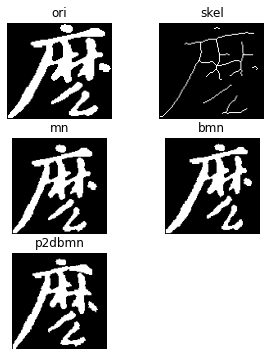

In [891]:
fname = '../data/shufadict/clean/发/2fc5822be330238690204267753d14c2.png'
fname = '../data/shufadict/clean/发/25c7c8b5d972ffd69870296df43a6884.png'
fname = '../data/shufadict/clean/而/5d2a6b1620b703e2f112c61d527585b9.png'
fname = '../data/shufadict/clean/而/9b00ab5a91f79fca33e8a8c1c0872643.png'
fname = '../data/shufadict/clean/而/f1e2bd97b285035a03de31e17fb0fd1a.png'
fname = '../data/shufadict/clean/说/2bed014d30fb1c554f84abeb24d64e6f.png'
# fname = '../data/shufadict/clean/说/4aa84d1b2c3528603b4c7e63dd9e0b8b.png'
# fname = '../data/shufadict/clean/那/8f5a4f9759115f2dc758d2253019c559.png'
# fname = '../data/shufadict/clean/那/af052eb17df40cf2de16c4c748991964.png'
# fname = '../data/shufadict/clean/人/e56dbd8247f81ef7dc1a31e27d307b82.png'
fname = '../data/shufadict/clean/么/0f34c618b9643d08a1469892702d2007.png'
img_init = cv2.imread(fname)[:, :, 0]
img_init = remove_padding(img_init)

img_mn = moment_normalization(img_init, get_mn_mapping, alpha=4, beta=2)
img_bmn = moment_normalization(img_init, get_bmn_mapping, alpha=4, beta=2)
img_mn_skel = moment_normalization_skel(img_init, get_mn_mapping, alpha=4, beta=2)
img_bmn_skel = moment_normalization_skel(img_init, get_bmn_mapping, alpha=4, beta=2)
img_p2dbmn = moment_normalization_skel(img_init, get_p2dbmn_mapping, alpha=4, beta=2)
show(
    [img_init, skeletonize(img_init//255), img_mn, img_bmn, 
#      img_mn_skel, img_bmn_skel,
     img_p2dbmn], 
    col=2, 
    titles=['ori', 'skel', 'mn', 'bmn', 
#             'mn_skel', 'bmn_skel',
            'p2dbmn'
           ]
)

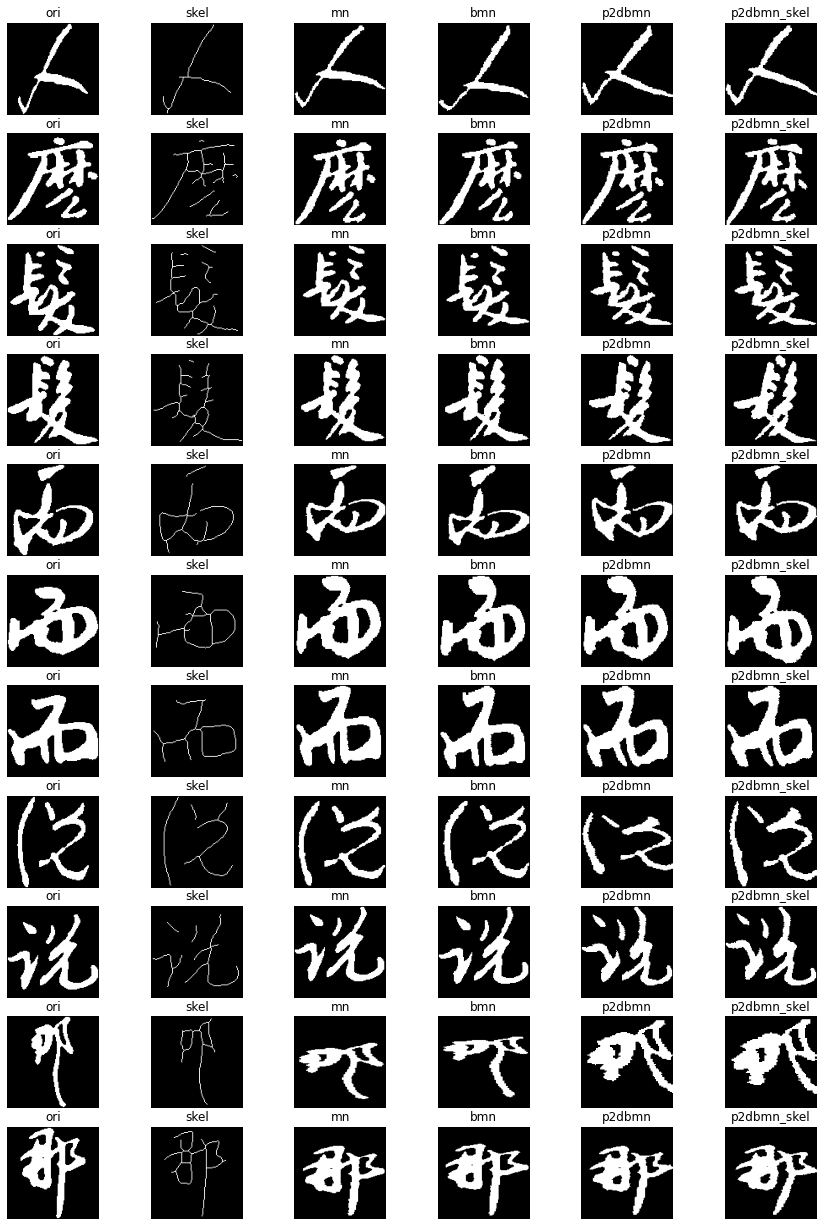

In [890]:
imgs = []
titles = []
fnames = [
    '../data/shufadict/clean/人/e56dbd8247f81ef7dc1a31e27d307b82.png',
    '../data/shufadict/clean/么/0f34c618b9643d08a1469892702d2007.png',
    '../data/shufadict/clean/发/2fc5822be330238690204267753d14c2.png',
    '../data/shufadict/clean/发/25c7c8b5d972ffd69870296df43a6884.png',
    '../data/shufadict/clean/而/5d2a6b1620b703e2f112c61d527585b9.png',
    '../data/shufadict/clean/而/9b00ab5a91f79fca33e8a8c1c0872643.png',
    '../data/shufadict/clean/而/f1e2bd97b285035a03de31e17fb0fd1a.png',
    '../data/shufadict/clean/说/2bed014d30fb1c554f84abeb24d64e6f.png',
    '../data/shufadict/clean/说/4aa84d1b2c3528603b4c7e63dd9e0b8b.png',
    '../data/shufadict/clean/那/8f5a4f9759115f2dc758d2253019c559.png',
    '../data/shufadict/clean/那/af052eb17df40cf2de16c4c748991964.png'
]
for fname in fnames:
    
    img_init = cv2.imread(fname)[:, :, 0]
    img_init = remove_padding(img_init)
    
    img_mn = moment_normalization(img_init, get_mn_mapping, alpha=4, beta=2)
    img_bmn = moment_normalization(img_init, get_bmn_mapping, alpha=4, beta=2)
    img_mn_skel = moment_normalization_skel(img_init, get_mn_mapping, alpha=4, beta=2)
    img_bmn_skel = moment_normalization_skel(img_init, get_bmn_mapping, alpha=4, beta=2)
    img_p2dbmn = moment_normalization(img_init, get_p2dbmn_mapping, alpha=4, beta=2)
    img_p2dbmn_skel = moment_normalization_skel(img_init, get_p2dbmn_mapping, alpha=4, beta=2)
    
    imgs += [img_init, skeletonize(img_init//255), 
             img_mn, img_bmn, 
#              img_mn_skel, img_bmn_skel,
             img_p2dbmn, img_p2dbmn_skel
            ]
    titles += ['ori', 'skel',
               'mn', 'bmn', 
#                'mn_skel', 'bmn_skel',
               'p2dbmn', 'p2dbmn_skel'
              ]

imgs = [pad_to_square((img > 0).astype('uint8'), max(img.shape)) for img in imgs]
show(imgs, col=6, titles=titles)

---

# PDF estimation

In [796]:
import scipy.stats as stats
import random
from tqdm.notebook import tqdm
# from multiprocessing import Pool
from multiprocess import Pool

In [797]:
DATA_PATH = '../data/shufadict/clean'
N = 16

In [183]:
chars = [x for x in os.listdir(DATA_PATH) if x[0] != '.']
char_to_id = dict(zip(chars, range(len(chars))))

In [365]:
def preprocess_image_pdfe(img, N, norm_func):
    
    img = remove_padding(img)
    img_norm = norm_func(img, get_bmn_mapping, alpha=4)
    
    h, w = img_norm.shape
    if h > w:
        img_norm = cv2.resize(img_norm, (N, int(w / h * N)))
    else:
        img_norm = cv2.resize(img_norm, (int(h / w * N), N))
    img_norm = (img_norm > 0).astype('uint8')
    img_norm = pad_to_square(img_norm, N)
    
    return img_norm


def get_kernel_contour(kernel, N, step):
    # get meshgrid and its coordinates
    xx, yy = np.mgrid[0:N:step, 0:N:step]
    positions = np.vstack([xx.ravel(), yy.ravel()])

    # estimation
    f = np.reshape(kernel(positions).T, xx.shape)
    f = np.rot90(np.rot90(np.rot90(f)))
    
    return f

def plot_kernel_contour(kernel, N, step):
    
    f = get_kernel_contour(kernel, N, step)

    # plot
    fig = plt.figure(figsize=(3,3))
    ax = fig.gca()
    ax.set_xlim(0, N)
    ax.set_ylim(0, N)
    # ax.contourf(xx, yy, f, cmap='coolwarm')
    # ax.contour(xx, yy, f, colors='black')
    ax.imshow(np.rot90(f), cmap='coolwarm', extent=[0, N, 0, N])
    ax.axis("off")
    

## Preprocess data

In [185]:
train = {}
val = {}
test = {}

for char in tqdm(chars):
    path = os.path.join(DATA_PATH, char)
    fnames = [os.path.join(path, f) for f in os.listdir(path) if f[0] != '.']
    imgs = []

    for fname in fnames:
        img = cv2.imread(fname)[:, :, 0]
        img_norm = preprocess_image_pdfe(img, N, moment_normalization_skel)
        imgs.append(img_norm)

    random.shuffle(imgs)
    test[char] = imgs[0:20]
    val[char] = imgs[20:40]
    train[char] = imgs[40:]

  0%|          | 0/100 [00:00<?, ?it/s]

## PDF Estimation

In [186]:
Xs = [None] * len(chars)
kernels = [None] * len(chars)
for i in tqdm(range(len(chars))):
    char = chars[i]
    imgs = train[char]
    Xs[i] = np.concatenate([np.argwhere(img) for img in imgs], axis=0)
    kernels[i] = stats.gaussian_kde(Xs[i].T)

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:>

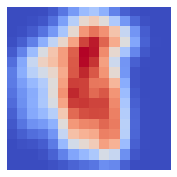

In [313]:
plot_kernel_contour(kernels[6], N=N, step=16j)

## Likelihood

In [201]:
test_preds = {}

for char in tqdm(test):
#     char_id = 23
    char_id = char_to_id[char]
    char = chars[char_id]

    preds = [[None] * len(chars) for _ in range(len(test[char]))]

    for i in (range(len(test[char]))):
        for j in range(len(chars)):
            coords = np.argwhere(test[char][i]).T  
            f = kernels[j](coords)
            preds[i][j] = np.log(f).sum()
            
    test_preds[char] = preds

  0%|          | 0/100 [00:00<?, ?it/s]

## Top-1 acc

In [265]:
accs = [None] * len(chars)
for char_id in range(len(chars)):
    preds = test_preds[chars[char_id]]
    accs[char_id] = (np.argmax(preds, axis=1) == char_id).sum() / 20
    
accs = np.array(accs)
accs.mean()

0.5980000000000001

Text(0, 0.5, 'freq')

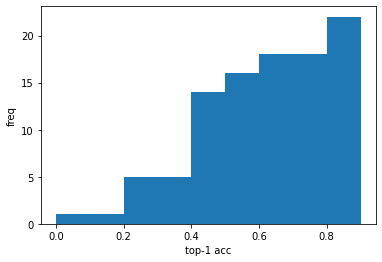

In [266]:
plt.hist(accs, [i/10 for i in range(10)])
plt.xlabel('top-1 acc')
plt.ylabel('freq')

## ...

In [267]:
np.argwhere(accs < 0.5)[:, 0]

array([ 0,  4,  7, 10, 13, 19, 21, 31, 36, 37, 40, 44, 52, 71, 72, 74, 75,
       79, 80, 83, 86, 87, 88, 89, 93, 99])

0 - 后 - pdf too similar to 这, variants
4 - 如 - too unconstrained
7 - 最 - variants, image too small?
10 - 国 - pdf too similar to 用同
13 - 看 - image too small???
19 - 就 - ???
21 - 发 - variants
31 - 从 - ???


? - variants 么

0.35


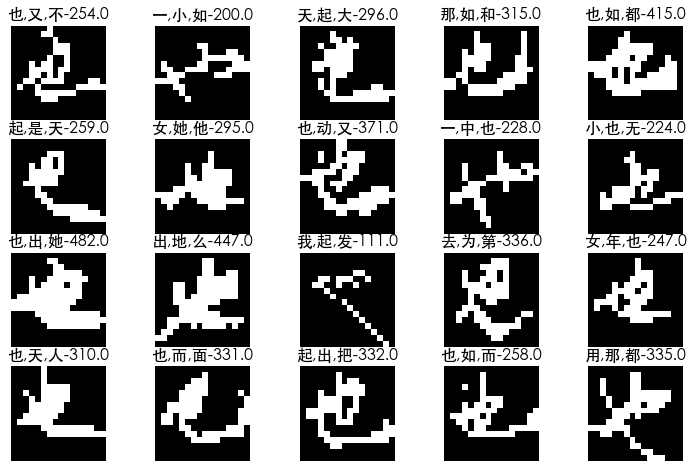

In [307]:
char_id = 37
char = chars[char_id]

print(accs[char_id])

preds = test_preds[chars[char_id]]

preds = np.array(preds)
preds_sorted = np.argsort(-preds, axis=1)
preds_rank = np.argwhere(preds_sorted == char_id)[:, 1]

titles = []
for i in range(len(test[char])):
    titles.append(','.join([chars[preds_sorted[i, j]] for j in range(3)]))
    titles[-1] += str(preds[i, preds_sorted[i, 0]].round())
    
show(test[char], titles=titles, chinese_title=True)
# show(train[char])

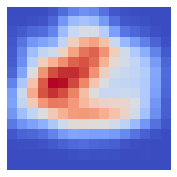

In [308]:
_ = plot_kernel_contour(kernels[char_id], N=N, step=16j)

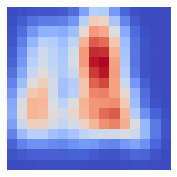

In [471]:
_ = plot_kernel_contour(kernels[char_to_id['后']], N=N, step=16j)

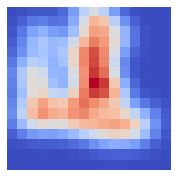

In [472]:
_ = plot_kernel_contour(kernels[char_to_id['这']], N=N, step=16j)

In [450]:
fs = [get_kernel_contour(kernels[char_id], N=N, step=16j) for char_id in range(len(chars))]

In [451]:
for i in range(len(fs)):
    fs[i] = (fs[i] - fs[i].min()) / (fs[i].max() - fs[i].min())

In [452]:
l2 = [[None] * len(fs) for _ in range(len(fs))]

for i in range(len(fs)):
    for j in range(i + 1, len(fs)):
        l2[i][j] = ((fs[i] - fs[j]) ** 2).sum() ** 0.5

In [454]:
i = 0
min(l2[i][i + 1:])

1.412209826046706

In [463]:
tmp = []
for i in range(len(l2) - 1):
    j = np.argmin(l2[i][i + 1:]) + 1 + i
    tmp.append((chars[i], chars[j], l2[i][j]))
#     print(chars[i], chars[j], l2[i][j])

In [467]:
sorted(tmp, key=lambda x: x[2])[50]

('如', '也', 2.160639354829893)

In [468]:
_ = plot_kernel_contour(kernels[3], N=N, step=16j)

NameError: name '如' is not defined

(0.0, 16.0, 0.0, 16.0)

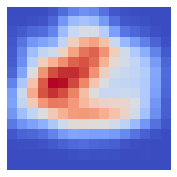

In [470]:
f = fs[char_to_id['也']]

fig = plt.figure(figsize=(3,3))
ax = fig.gca()
ax.set_xlim(0, N)
ax.set_ylim(0, N)
# ax.contourf(xx, yy, f, cmap='coolwarm')
# ax.contour(xx, yy, f, colors='black')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[0, N, 0, N])
ax.axis("off")

In [ ]:
# multiprocessing kde

# n_cores = 2
# char = '起'

# with Pool(n_cores) as pool:

#     preds = [[None] * len(chars) for _ in range(len(test[char]))]

#     for i in tqdm(range(len(test[char]))):
#         for j in range(len(chars)):
#             coords = np.argwhere(test[char][i]).T            
#             tasks = [(x, kernels[j]) for x in np.array_split(coords, n_cores, axis=1)]
#             results = pool.map(lambda x: x[1](x[0]), tasks)
#             preds[i][j] = sum([np.log(x).sum() for x in results])
        